<a href="https://colab.research.google.com/github/MatiasSiles/UNAHUR-Student-Dropout-2021/blob/main/Clustering_Studiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [238]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Carga Datos

In [239]:
df = pd.read_csv("https://www.dropbox.com/scl/fi/ujv131299jxbdie3erod5/students_data_raw.csv?rlkey=j07rkto0snj0fde1np6gkmqis&st=ltjkjc88&dl=1")
df_porcentajes = df[df['metrica'].str.contains('porcentaje')]
df_porcentajes.head()

,anio,nivel,instituto,tipo_estudiante,genero,metrica,valor
1,2021,Pregrado y Grado,UNAHUR,Todos,Todos,porcentaje_inscriptos_a_materias,65.0
2,2021,Pregrado y Grado,UNAHUR,Todos,Todos,porcentaje_no_inscriptos_a_materias,35.0
3,2021,Pregrado y Grado,UNAHUR,Todos,Todos,porcentaje_regularizo_o_aprobo,60.0
4,2021,Pregrado y Grado,UNAHUR,Todos,Todos,porcentaje_no_regularizo_ni_aprobo,40.0
6,2021,Pregrado y Grado,UNAHUR,No regularizó ni aprobó,Todos,porcentaje_se_inscribio_a_materia,65.0


Observacion: Este proyecto no aborda un modelo predictivo debido a que no se cuenta con datos individuales de cada estudiantes, ya que el dataset deberia de ser similar a la siguiente estructura:
| estudiante_id | anio  | nivel    | instituto | tipo_estudiante | genero | promedio_notas | asistencias (%) | desercion (0=no, 1=sí) |
| ------------- | ---- | -------- | --------- | --------------- | ------ | -------------- | --------------- | ---------------------- |
| 001           | 2023 | Pregrado | UNAHUR    | Regular         | M      | 7.5            | 85              | 0                      |
| 002           | 2023 | Pregrado | UNAHUR    | Regular         | F      | 5.2            | 60              | 1                      |
| 003           | 2023 | Posgrado | UNAHUR    | Becado          | M      | 8.0            | 90              | 0                      |
| 004           | 2023 | Pregrado | UNAHUR    | Regular         | F      | 4.8            | 50              | 1                      |


#Preprocesamiento

In [240]:
# Variables relevantes clustering
df_clustering = df_porcentajes[['nivel', 'tipo_estudiante', 'genero', 'valor']].copy()

In [241]:
# One hot encoding
df_clustering = pd.get_dummies(df_clustering, columns=['nivel', 'tipo_estudiante', 'genero'], drop_first=True)
df_clustering.update(df_clustering.select_dtypes(include='bool').astype(int))
df_clustering.head()

,valor,nivel_Posgrado,nivel_Pregrado,nivel_Pregrado y Grado,tipo_estudiante_No regularizó ni aprobó,tipo_estudiante_Nuevos/as Inscriptos/as,tipo_estudiante_Nuevos/as Inscriptos/as en 2021,tipo_estudiante_Reinscriptos/as,tipo_estudiante_Reinscriptos/as en 2021,tipo_estudiante_Todos,genero_Todos,genero_Varones
1,65.0,0,0,1,0,0,0,0,0,1,1,0
2,35.0,0,0,1,0,0,0,0,0,1,1,0
3,60.0,0,0,1,0,0,0,0,0,1,1,0
4,40.0,0,0,1,0,0,0,0,0,1,1,0
6,65.0,0,0,1,1,0,0,0,0,0,1,0


Normalizar la columna "valor" para que no perjudique al calcular las medias durante las predicciones de k-means. Mientas que las columnas binarias creadas por One Hot Encoding no necesitan ser normalizadas ya que estas ya estan en una escala

In [242]:
df_clustering["valor"] = df_clustering["valor"] / 100
df_clustering.head(5)

,valor,nivel_Posgrado,nivel_Pregrado,nivel_Pregrado y Grado,tipo_estudiante_No regularizó ni aprobó,tipo_estudiante_Nuevos/as Inscriptos/as,tipo_estudiante_Nuevos/as Inscriptos/as en 2021,tipo_estudiante_Reinscriptos/as,tipo_estudiante_Reinscriptos/as en 2021,tipo_estudiante_Todos,genero_Todos,genero_Varones
1,0.65,0,0,1,0,0,0,0,0,1,1,0
2,0.35,0,0,1,0,0,0,0,0,1,1,0
3,0.60,0,0,1,0,0,0,0,0,1,1,0
4,0.40,0,0,1,0,0,0,0,0,1,1,0
6,0.65,0,0,1,1,0,0,0,0,0,1,0


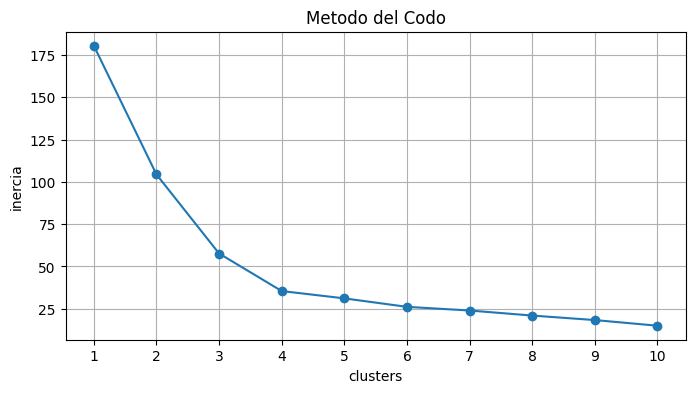

In [248]:
# Usar el metodo del codo para encontrar el numero optimo de clusters
inercias = []
for c in range(1, 11):
    kmeans = KMeans(n_clusters=c, init='k-means++', random_state=42)
    kmeans.fit(df_clustering)
    inercias.append(kmeans.inertia_)

# Graficar el metodo del codo
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inercias, marker='o')
plt.title('Metodo del Codo')
plt.xlabel('clusters')
plt.ylabel('inercia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

*   Nota: Tenemos 2 candidatos, el cluster 3 y 4 empieza a aplanarse la linea

#Clustering

In [259]:
#Entrenamiento y Predicciones con 3 clusters
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
df_clustering['cluster_3'] = kmeans_3.fit_predict(df_clustering)

In [260]:
#Entrenamiento y Predicciones con 4 clusters
kmeans_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
df_clustering['cluster_4'] = kmeans_4.fit_predict(df_clustering)

In [246]:
#Visualizacion detallada de los clusters
cluster_means_3 = df_clustering.groupby('cluster_3').mean()
cluster_means_3 = cluster_means_3.drop("cluster_4", axis=1)
cluster_means_3.round(2)

,valor,nivel_Posgrado,nivel_Pregrado,nivel_Pregrado y Grado,tipo_estudiante_No regularizó ni aprobó,tipo_estudiante_Nuevos/as Inscriptos/as,tipo_estudiante_Nuevos/as Inscriptos/as en 2021,tipo_estudiante_Reinscriptos/as,tipo_estudiante_Reinscriptos/as en 2021,tipo_estudiante_Todos,genero_Todos,genero_Varones
cluster_3,,,,,,,,,,,,
0,0.46,0.13,0.4,0.0,0.0,0.33,0.0,0.0,0.0,0.67,0.0,0.5
1,0.66,0.17,0.5,0.0,0.0,0.00,0.0,1.0,0.0,0.00,0.0,0.5
2,0.60,0.00,0.1,0.6,0.2,0.00,0.1,0.0,0.1,0.40,1.0,0.0


*   Observacion:

In [247]:
cluster_means_4 = df_clustering.groupby('cluster_4').mean()
cluster_means_4 = cluster_means_4.drop("cluster_3", axis=1)
display(cluster_means_4.round(2))

,valor,nivel_Posgrado,nivel_Pregrado,nivel_Pregrado y Grado,tipo_estudiante_No regularizó ni aprobó,tipo_estudiante_Nuevos/as Inscriptos/as,tipo_estudiante_Nuevos/as Inscriptos/as en 2021,tipo_estudiante_Reinscriptos/as,tipo_estudiante_Reinscriptos/as en 2021,tipo_estudiante_Todos,genero_Todos,genero_Varones
cluster_4,,,,,,,,,,,,
0,0.42,0.20,0.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.66,0.17,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.5
2,0.60,0.00,0.1,0.6,0.2,0.0,0.1,0.0,0.1,0.4,1.0,0.0
3,0.48,0.10,0.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5


## Conclusiones, Sugerencias y Observaciones

A partir del análisis exploratorio y el clustering realizado en este notebook, se pueden extraer los siguientes hallazgos importantes:

**Hallazgos Importantes:**

*   El método del codo sugiere que tanto 3 como 4 clusters son candidatos potenciales para agrupar los datos.
*   Al analizar las medias de las características por cluster, se observan diferencias claras entre los grupos formados tanto con 3 como con 4 clusters.
    *   **Con 3 Clusters:** Se identifican grupos con valores promedio de métricas porcentuales bajos, medios y altos. Esto podría indicar diferentes niveles de rendimiento o compromiso estudiantil.
    *   **Con 4 Clusters:** La división en 4 clusters parece refinar aún más estas agrupaciones, posiblemente separando subgrupos dentro de los niveles medio y alto, o aislando un grupo con características más extremas. Por ejemplo, el Cluster 3 en la solución de 4 clusters tiene un valor promedio significativamente más alto y una mayor proporción de estudiantes de Posgrado y Reinscriptos/as.
*   Las variables como el nivel de estudio (Pregrado, Grado, Posgrado), el tipo de estudiante (Nuevos/as Inscriptos/as, Reinscriptos/as, etc.) y el género parecen influir en la formación de los clusters, como se refleja en las medias de estas variables codificadas.

**Sugerencias:**

*   Evaluar mas a fondo las caracteristicas de los clusters con 3 y 4 agrupaciones para determinar cuál de las dos soluciones de clustering ofrece una interpretación más significativa
*   Considerar la posibilidad de incorporar otras variables individuales de los estudiantes para construir un modelo de prediccion

**Observaciones:**

*   El conjunto de datos utilizado se basa en metricas porcentuales agregadas, lo cual es util para un analisis a nivel grupal, pero limita la capacidad de predecir la desercion a nivel individual.
*   La interpretacion de los clusters en espacios de alta dimensión (despues del one-hot encoding) puede ser desafiante y requiere un analisis cuidadoso de las medias de las características.
*   La elección final del número de clusters dependerá del equilibrio entre la interpretabilidad de los clusters y la reducción de la inercia (WCSS), así como del objetivo específico del analisis.

Este analisis inicial proporciona una base para comprender los diferentes perfiles de estudiantes presentes en los datos. Los siguientes pasos deberian centrarse en refinar la interpretacion de los clusters para elegir si al final son 3 o 4 grupos y obtener datos individuales de los estudiantes para crear un modelo predictivo